In [ ]:
%whos

In [1]:
key = pd.read_csv('../data/key.csv')
train = pd.read_csv('../data/train.csv')
weather = pd.read_csv('../data/weather.csv')
test = pd.read_csv('../data/test.csv')

In [2]:
train['log_units'] = np.log(train['units'] + 1)
train.tail()

,date,store_nbr,item_nbr,units,log_units
4617595,2014-10-31,45,107,0,0.0
4617596,2014-10-31,45,108,0,0.0
4617597,2014-10-31,45,109,0,0.0
4617598,2014-10-31,45,110,0,0.0
4617599,2014-10-31,45,111,0,0.0


In [3]:
train_new = train[:2255853] # 2013년 3월 31일까지의 train data

In [4]:
weather_train = weather[:8968] # 2013년 3월 31일까지의 weather data

### weather 관련 functions

In [5]:
def get_weather_train(df, station_nbr) : # staion_nbr에 따라서 weather train dataframe을 만드는 함수
    new_df = df[df['station_nbr'] == station_nbr]
    new_df.reset_index(drop = True, inplace = True)
    return new_df    

In [6]:
def set_tmax(df) : # tmax의 missing value를 처리하는 함수
    for num in range(len(df)) :  # tmax의 missing value 처리,,, 이틀 전날의 0.2배 + 하루 전날의 0.8배
        if df.at[num, 'tmax'] == 'M' :
            df.set_value(num, 'tmax', float(0.2 * int(df.at[num - 2, 'tmax']) + 0.8 * float(df.at[num - 1, 'tmax'])))
        
        else :
            df.at[num, 'tmax'] = float(df.at[num, 'tmax'])

In [7]:
def set_tmin(df) : # tmin의 missing value를 처리하는 함수
    for num in range(len(df)) :  # tmax의 missing value 처리,,, 이틀 전날의 0.2배 + 하루 전날의 0.8배
        if df.at[num, 'tmin'] == 'M' :
            df.set_value(num, 'tmin', float(0.2 * int(df.at[num - 2, 'tmin']) + 0.8 * float(df.at[num - 1, 'tmin'])))
            
        else :
            df.at[num,'tmin'] = float(df.at[num, 'tmin'])

In [8]:
def set_tavg(df) : # tavg의 값을 처리하는 함수
    for num in range(len(df)) :
        if df.at[num, 'tavg'] == 'M' :
            df.set_value(num, 'tavg', float((df.at[num, 'tmax'] + df.at[num, 'tmin']) / 2)) # (tmax + tmin) / 2
            
        else :
            df.at[num, 'tavg'] = float(df.at[num, 'tavg'])   

In [9]:
def set_depart(df) : # how can I get depart value..wtf
    if df.at[0, 'depart'] == 'M' :
        print("Cannot get depart value") # depart값을 구할 수 없는 경우
            
    else :
        depart_base = float(df.at[0, 'tavg']) - float(df.at[0, 'depart']) # 각 weather station을 보면 tavg - depart값이 일정하다.. 개이득..
        for num in range(1, len(df)) :
            df.set_value(num, 'depart', float((df.at[num, 'tavg'] - depart_base)))

In [10]:
def set_dewpoint(df) : 
    for num in range(len(df)) :
        if df.at[num, 'dewpoint'] == 'M' :
            df.set_value(num, 'dewpoint', np.nan)

In [11]:
def set_wetbulb(df) : # 습구온도는 불포화공기에서는 건구온도보다 낮고 노점(이슬점, dewpoint)보다 높지만, 포화공기에서 3자는 일치한다.
    for num in range(len(df)) :
        if df.at[num, 'wetbulb'] == 'M' :
            df.set_value(num, 'wetbulb', np.nan)

In [12]:
def set_heat_cool(df) : # heat, cool의 missing value 처리
    for num in range(len(df)) :
        if df.at[num, 'heat'] == 'M' or df.at[num, 'cool'] == 'M' :
            
            if df.at[num, 'tavg'] == 65 : # tavg == 65 이면 heat, cool 모두 0
                df.set_value(num, 'heat', 0)
                df.set_value(num, 'cool', 0)
            
            elif df.at[num, 'tavg'] > 65 : #tavg > 65 이면 heat = 0, cool = tavg - 65
                df.set_value(num, 'heat', 0)
                df.set_value(num, 'cool', float(df.at[num, 'tavg'] - 65))
            
            else : #tavg < 65 이면 heat = 65 - tavg, cool = 0
                df.set_value(num, 'heat', float(65 - df.at[num, 'tavg']))
                df.set_value(num, 'cool', 0)

In [13]:
def merge_heat_cool(df) :
    df['heat_cool'] = ""
    
    for num in range(len(df)) :
        df.set_value(num, "heat_cool", int(df.at[num, "cool"]) - int(df.at[num, "heat"]))

In [14]:
def set_snowfall_preciptotal(df) : #codesum에 RA가 있는데 preciptotal이 T인경우도있다...
    for num in range(len(df)) :
        if ('T' in df.at[num, 'snowfall']) or ('M' in df.at[num, 'snowfall']) : # snowfall이 trace or M이면 0으로 setting
            df.set_value(num, 'snowfall', 0.0)
        
        if ('T' in df.at[num, 'preciptotal']) or ('M' in df.at[num, 'preciptotal']) : # preciptotal이 trace or M이면 0으로 setting
            df.set_value(num, 'preciptotal', 0.0)

In [15]:
def set_stnpressure(df) :
    for num in range(len(df)) :
        if df.at[num, 'stnpressure'] == 'M' :
            df.set_value(num, 'stnpressure', np.nan)

In [16]:
def set_sealevel(df) :
    for num in range(len(df)) :
        if df.at[num, 'sealevel'] == 'M' :
            df.set_value(num, 'sealevel', np.nan)

In [17]:
def set_resultspeed(df) : # 바람관련 column 3개는 어떤 연관관계가 있지않을까..
#     The fastest 2-minute (average) wind speed, in Miles Per Hour.
    for num in range(len(df)) :
        if df.at[num, 'resultspeed'] == 'M' :
            df.set_value(num, 'resultspeed', np.nan)

In [18]:
def set_resultdir(df) :
#     resultdir : The direction the fastest 2-minute wind was blowing FROM in tens of degrees
#     27 would be 270 degrees = wind was blowing from the west to the east
#     (36 = North, 09 = East, 18 = South, 27 = West)
    for num in range(len(df)) :
        if df.at[num, 'resultdir'] == 'M' :
            df.set_value(num, 'resultdir', np.nan)

In [19]:
def set_avgspeed(df) :
#     The average wind speed for the day, in Miles Per Hour
    for num in range(len(df)) :
        if df.at[num, 'avgspeed'] == 'M' :
            df.set_value(num, 'avgspeed', np.nan)

In [20]:
def set_event(df) :
    df['event'] = ""
    
    df['snowfall'] = df['snowfall'].astype('float')
    df['preciptotal'] = df['preciptotal'].astype('float')
    
    for num in range(len(df)) :
        if df.at[num, 'snowfall'] >= 2.0 or df.at[num, 'preciptotal'] >= 1.0 :
            df.set_value(num, 'event', 1)
            
        else :
            df.set_value(num, 'event', 0)

### train 관련 functions

In [21]:
def get_train_train(df, store_nbr) : # store_nbr에 따라 train data를 나눠주는 함수
    new_df = df[df['store_nbr'] == store_nbr]
    new_df.reset_index(drop = True, inplace = True)
    return new_df

### weather와 train data를 합쳐주는 함수
- train data 중 log_units != 0 인 item들만 합쳐줌.. (log_units != 0 이면 units != 0)

In [22]:
def merge_weather_train(weather, train) :
    train_pivot = train.pivot_table(values = 'log_units', index = ['date'], columns = ['item_nbr'])
    train_pivot = train_pivot.loc[:, (train_pivot != 0).any(axis = 0)] # log_units이 모두 0인 item_nbr(column)을 삭제..
    train_pivot.loc['2012-12-25'] = 0 # 2012-12-25의 data를 0으로 추가... 원래 없었던 data이므로 0으로 설정함
    
    list_item_nbr = train_pivot.columns # units 전체가 0이 아닌 item_nbr들을 list형태로 받음
#     length = len(train_pivot.columns) # units전체가 0이 아닌 item_nbr이 총 몇개 있는지..
        
    train_pivot.index.name = "date"
    train_pivot.reset_index(inplace = True)
    train_pivot.sort_values(by = 'date', inplace = True)
    train_pivot.reset_index(drop = True, inplace = True)
    
    for num in list_item_nbr :
        weather[num] = train_pivot[num]
    
    return weather

In [23]:
def get_item_nbr(df) : # 모든 units이 0이 아닌 item_nbr을 구하는 함수, list형태로 return
    tmp = df.pivot_table(values = 'log_units', index = ['date'], columns = ['item_nbr'])
    tmp = tmp.loc[:, (tmp != 0).any(axis = 0)]
    tmp.loc['2012-12-25'] = 0 # 2012-12-25가 빠져있음 train data에서.. 그래서 log_units = 0으로 넣어줌.
    
    tmp.reset_index(inplace = True)
    tmp.sort_values(by = 'date', inplace = True)
    tmp.drop(['date'], axis = 1, inplace = True)
    
    result = list(tmp.columns)
    
    return result

In [24]:
def match_dateformat(df, year):
    """
    영문 월을 숫자 월로 바꾸어주고 나중에 사용하기 쉽도록 datetime.date 형태로 바꾸어주는 함수
    """
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    for i in range(len(df)):
        dates = df.loc[i][0]
        dates = dates.split(" ")
        for j in range(len(months)):
            if dates[0] == months[j]:
                dates[0] = str(j + 1)
                dates_df = ["{} {} {}".format(year, dates[0], dates[1])]
                dates_df = pd.to_datetime(dates_df)
                df.loc[i][0] = dates_df.date[0]
    return df

In [25]:
def merge_holiday(holiday_df1, holiday_df2, holiday_df3):
    """
    각 연도별 공휴일 리스트 합치기
    """
    frame = [holiday_df1, holiday_df2, holiday_df3]
    holiday = pd.concat(frame).reset_index(drop=True)
    return holiday

In [26]:
def find_holiday(file, year):
    """
    수요에 영향을 미치는 주요 공휴일을 찾아내는 함수
    """
    holidays = ["New Year's Day", "Martin Luther King Jr. Day", "Valentine's Day",  "President's Day", "Easter Sunday", 
                      "Mother's Day", "Memorial Day", "Father's Day", "Independence Day", "Labor Day", "Columbus Day",
                      "Halloween", "Veterans Day", "Thanksgiving Day", "Black Friday", "Christmas Eve", "Christmas Day", "New Year's Eve"]
    
    holi = pd.read_excel(file, year, header=None)
    holi = match_dateformat(holi, year)
    holiday = pd.DataFrame(columns=[0,1,2,3,4])
    for _ in holidays:
        for i in range(len(holi[2])):
            if _ == holi[2][i]:
                holiday = holiday.append(holi.loc[i])
    return holiday

In [27]:
def test_preprocessing(df, holiday, weather):
    df['date'] = pd.to_datetime(df['date'])
    df['weekday'] = df.date.dt.weekday  # 월요일이 0 일요일이 6
    df['weekend'] = df.date.dt.weekday.isin([5, 6])  # 5: 토요일, 6: 일요일

    df['holiday'] = df.date.isin(holiday[0])
    
    df = pd.merge(df, key, on='store_nbr') #key는 글로벌 변수
    df = pd.merge(df, weather[['date', 'station_nbr', 'event']], on=['date', 'station_nbr'])
    return df

In [28]:
holiday12 = find_holiday('../data/holiday.xlsx', '2012')
holiday13 = find_holiday('../data/holiday.xlsx', '2013')
holiday14 = find_holiday('../data/holiday.xlsx', '2014')
holiday = merge_holiday(holiday12, holiday13, holiday14)

In [29]:
weather_train['date'] = pd.to_datetime(weather_train['date'])
weather_train['weekday'] = weather_train.date.dt.weekday  # 월요일이 0 일요일이 6

weather_train['holiday'] = weather_train.date.isin(holiday[0])

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexi

In [30]:
#station_nbr로 weather_train을 나눠줌
# 박두진 강사님이 이 부분을 줄일 수 있는 방법을 찾아봐주신다 하였음..일단은 그냥 쓰자!

weather_train_1 = get_weather_train(weather_train, 1)
weather_train_2 = get_weather_train(weather_train, 2)
weather_train_3 = get_weather_train(weather_train, 3)
weather_train_4 = get_weather_train(weather_train, 4)
weather_train_5 = get_weather_train(weather_train, 5) # missing value가 많아서 일단은..
weather_train_6 = get_weather_train(weather_train, 6)
weather_train_7 = get_weather_train(weather_train, 7)
weather_train_8 = get_weather_train(weather_train, 8)
weather_train_9 = get_weather_train(weather_train, 9)
weather_train_10 = get_weather_train(weather_train, 10)
weather_train_11 = get_weather_train(weather_train, 11)
weather_train_12 = get_weather_train(weather_train, 12)
weather_train_13 = get_weather_train(weather_train, 13)
weather_train_14 = get_weather_train(weather_train, 14)
weather_train_15 = get_weather_train(weather_train, 15)
weather_train_16 = get_weather_train(weather_train, 16)
weather_train_17 = get_weather_train(weather_train, 17)
weather_train_18 = get_weather_train(weather_train, 18)
weather_train_19 = get_weather_train(weather_train, 19)
weather_train_20 = get_weather_train(weather_train, 20)

In [31]:
train_new_1 = get_train_train(train_new, 1)
train_new_2 = get_train_train(train_new, 2)
train_new_3 = get_train_train(train_new, 3)
train_new_4 = get_train_train(train_new, 4)
train_new_5 = get_train_train(train_new, 5)
train_new_6 = get_train_train(train_new, 6)
train_new_7 = get_train_train(train_new, 7)
train_new_8 = get_train_train(train_new, 8)
train_new_9 = get_train_train(train_new, 9)
train_new_10 = get_train_train(train_new, 10)
train_new_11 = get_train_train(train_new, 11)
train_new_12 = get_train_train(train_new, 12)
train_new_13 = get_train_train(train_new, 13)
train_new_14 = get_train_train(train_new, 14)
train_new_15 = get_train_train(train_new, 15)
train_new_16 = get_train_train(train_new, 16)
train_new_17 = get_train_train(train_new, 17)
train_new_18 = get_train_train(train_new, 18)
train_new_19 = get_train_train(train_new, 19)
train_new_20 = get_train_train(train_new, 20)
train_new_21 = get_train_train(train_new, 21)
train_new_22 = get_train_train(train_new, 22)
train_new_23 = get_train_train(train_new, 23)
train_new_24 = get_train_train(train_new, 24)
train_new_25 = get_train_train(train_new, 25)
train_new_26 = get_train_train(train_new, 26)
train_new_27 = get_train_train(train_new, 27)
train_new_28 = get_train_train(train_new, 28)
train_new_29 = get_train_train(train_new, 29)
train_new_30 = get_train_train(train_new, 30)
train_new_31 = get_train_train(train_new, 31)
train_new_32 = get_train_train(train_new, 32)
train_new_33 = get_train_train(train_new, 33)
train_new_34 = get_train_train(train_new, 34)
train_new_35 = get_train_train(train_new, 35)
train_new_36 = get_train_train(train_new, 36)
train_new_37 = get_train_train(train_new, 37)
train_new_38 = get_train_train(train_new, 38)
train_new_39 = get_train_train(train_new, 39)
train_new_40 = get_train_train(train_new, 40)
train_new_41 = get_train_train(train_new, 41)
train_new_42 = get_train_train(train_new, 42)
train_new_43 = get_train_train(train_new, 43)
train_new_44 = get_train_train(train_new, 44)
train_new_45 = get_train_train(train_new, 45)

In [32]:
test['date'] = pd.to_datetime(test['date'])

In [ ]:
test.tail()

In [33]:
set_snowfall_preciptotal(weather)
set_event(weather)

In [34]:
test['date'] = pd.to_datetime(test['date'])
weather['date'] = pd.to_datetime(weather['date'])

test_ = test_preprocessing(test, holiday, weather)

In [ ]:
test_.tail()

## 각 dataframe별로 뒤에 붙는 숫자에 주의해야함
- station_nbr 기준인지 store_nbr 기준인지...

In [134]:
result_test = []

### station_nbr별 특징
- no depart value : 1, 7, 8, 9, 10, 12, 13, 16, 17, 20
    - drop??

### station_nbr == 1
- store_nbr == 1
- no depart value

In [36]:
set_tmax(weather_train_1)
set_tmin(weather_train_1)
set_tavg(weather_train_1)
set_heat_cool(weather_train_1)
merge_heat_cool(weather_train_1)
set_depart(weather_train_1)
set_snowfall_preciptotal(weather_train_1)
set_dewpoint(weather_train_1)
set_wetbulb(weather_train_1)
set_stnpressure(weather_train_1)
set_sealevel(weather_train_1)
set_resultspeed(weather_train_1)
set_resultdir(weather_train_1)
set_avgspeed(weather_train_1)
set_event(weather_train_1)

# merged_1 = merge_weather_train(weather_train_1, train_new_1)
item_nbr_list_1 = get_item_nbr(train_new_1)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#in

Cannot get depart value


In [215]:
test_1 = test_[test_['station_nbr'] == 1]

test_1['weekday'] = test_1.date.dt.weekday  # 월요일이 0 일요일이 8
test_1['holiday'] = test_1.date.isin(holiday[0])

train_new_1['date'] = pd.to_datetime(train_new_1['date'])

df = pd.merge(train_new_1, key, on = 'store_nbr')
df = pd.merge(df, weather_train_1, on = ['date', 'station_nbr'])

model = sm.OLS.from_formula('log_units ~ C(store_nbr):C(item_nbr) + C(weekday) + C(holiday) + C(event) + 0', data = df)
result_model = model.fit()
print(result_model.summary())

test_1.reset_index(drop = True, inplace = True)
test_1['log_units'] = result_model.predict(test_1)
test_1['units'] = np.exp(test_1['log_units']) - 1

for num in range(len(test_1)) :
    if test_1.at[num, 'item_nbr'] not in item_nbr_list_1 :
        test_1.set_value(num, 'units', 0.0)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

                            OLS Regression Results                            
Dep. Variable:              log_units   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     2121.
Date:                Tue, 06 Mar 2018   Prob (F-statistic):               0.00
Time:                        16:59:48   Log-Likelihood:                 21989.
No. Observations:               50505   AIC:                        -4.374e+04
Df Residuals:                   50386   BIC:                        -4.269e+04
Df Model:                         118                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
C(weekday)[0]         -0.0027      0

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [135]:
result_test.append(test_1)

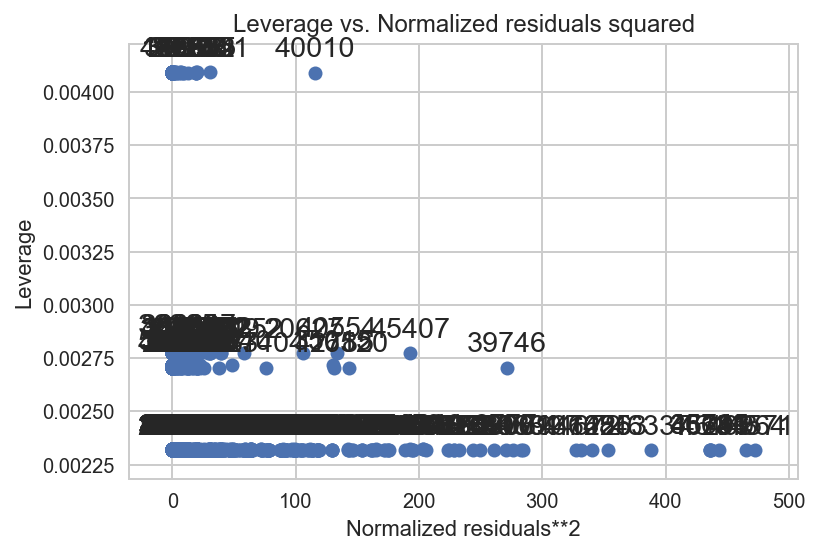

In [218]:
sm.graphics.plot_leverage_resid2(result_model)
plt.show()

In [222]:
fig = plt.figure(figsize=(8, 400))
sm.graphics.plot_partregress_grid(result_model, fig=fig)
fig.suptitle("")
plt.show()

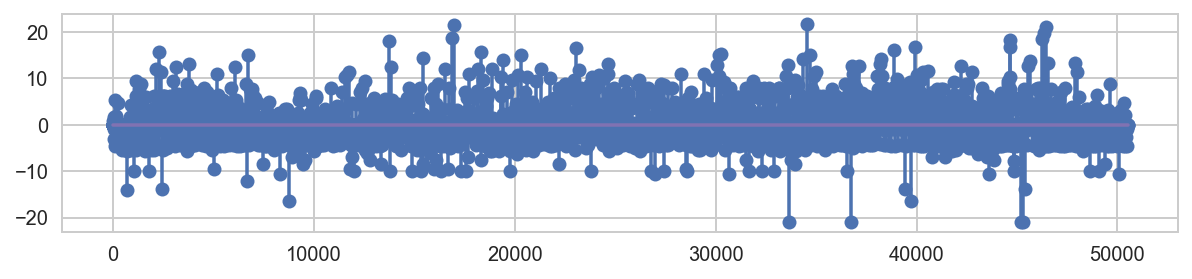

In [223]:
plt.figure(figsize=(10, 2))
plt.stem(result_model.resid_pearson)
plt.show()

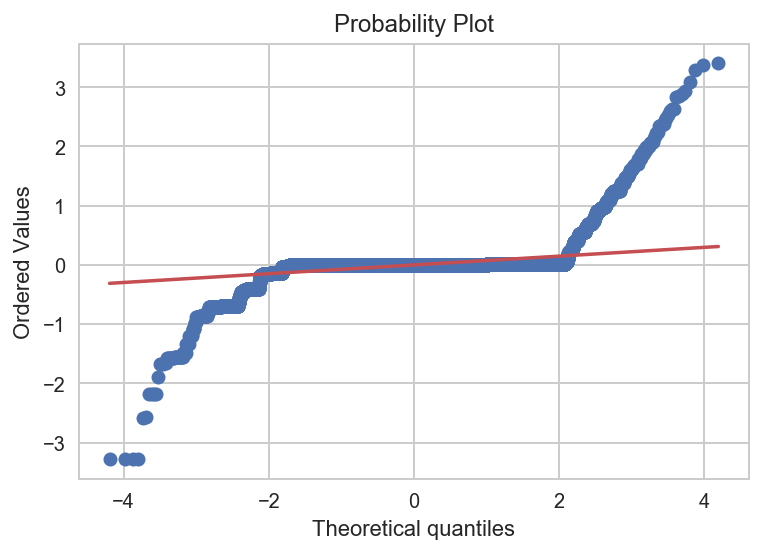

In [224]:
sp.stats.probplot(result_model.resid, plot=plt)
plt.show()

###  station_nbr == 2
- store_nbr == 16

In [39]:
set_tmax(weather_train_2)
set_tmin(weather_train_2)
set_tavg(weather_train_2)
set_heat_cool(weather_train_2)
merge_heat_cool(weather_train_2)
set_depart(weather_train_2)
set_snowfall_preciptotal(weather_train_2)
set_dewpoint(weather_train_2)
set_wetbulb(weather_train_2)
set_stnpressure(weather_train_2)
set_sealevel(weather_train_2)
set_resultspeed(weather_train_2)
set_resultdir(weather_train_2)
set_avgspeed(weather_train_2)
set_event(weather_train_2)

# merged_2 = merge_weather_train(weather_train_2, train_new_16)
item_nbr_list_2 = get_item_nbr(train_new_16)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#in

In [40]:
test_2 = test_[test_['station_nbr'] == 2]

test_2['weekday'] = test_2.date.dt.weekday  # 월요일이 0 일요일이 8
test_2['holiday'] = test_2.date.isin(holiday[0])

train_new_16['date'] = pd.to_datetime(train_new_16['date'])

df = pd.merge(train_new_16, key, on = 'store_nbr')
df = pd.merge(df, weather_train_2, on = ['date', 'station_nbr'])

model = sm.OLS.from_formula('log_units ~ C(store_nbr):C(item_nbr) + C(weekday) + C(holiday) + C(event) + 0', data = df)
result_model = model.fit()
print(result_model.summary())

test_2.reset_index(drop = True, inplace = True)
test_2['log_units'] = result_model.predict(test_2)
test_2['units'] = np.exp(test_2['log_units']) - 1

for num in range(len(test_2)) :
    if test_2.at[num, 'item_nbr'] not in item_nbr_list_2 :
        test_2.set_value(num, 'units', 0.0)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

                            OLS Regression Results                            
Dep. Variable:              log_units   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.956
Method:                 Least Squares   F-statistic:                     9281.
Date:                Tue, 06 Mar 2018   Prob (F-statistic):               0.00
Time:                        15:39:47   Log-Likelihood:                 32880.
No. Observations:               50505   AIC:                        -6.552e+04
Df Residuals:                   50386   BIC:                        -6.447e+04
Df Model:                         118                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
C(weekday)[0]         -0.0007      0

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [136]:
result_test.append(test_2)

In [ ]:
plt.figure(figsize = (10, 20))
plotcount = 1
for num in item_nbr_list_2 :
    plt.subplot(len(item_nbr_list_2), 1, plotcount)
    plt.scatter(x = merged_2['tmax'], y = merged_2[num]) # x에 들어가는 column을 바꿔가며 관계시각화 가능..pairplot은 왜 안되지 ㅅㅂ
    
    plt.ylabel('log_units')
#     plt.ylabel('log_units of item_nbr == {}'.format(num))

    plt.title('item_nbr == {}'.format(num))
        
    plotcount += 1

In [ ]:
weather_train_2_test = weather_train_2.drop(['station_nbr', 'date', 'sunrise', 'sunset', 'codesum', 'heat', 'cool'], axis = 1)

train_new_16_pivot = train_new_16.pivot_table(values = 'log_units', index = ['date'], columns = ['item_nbr'])
# train_new_16_pivot.loc[len(train_new_16)] = 0
# train_new_16_pivot.reset_index(drop = True, inplace = True)

train_new_16_pivot = pd.DataFrame(np.insert(train_new_16_pivot.values, 359, values = 0, axis = 0))

for num in item_nbr_list_2 :
    dfX = sm.add_constant(weather_train_1_test)
    dfy = pd.DataFrame(np.asarray(train_new_16_pivot[num - 1]), columns=["item_nbr == {}".format(num)])

    model = sm.OLS(dfy.astype(float), dfX.astype(float), missing = 'drop')
    result_model = model.fit()
    print(result_model.summary())

### station_nbr == 3
- store_nbr == 21, 29, 33

In [42]:
result = pd.concat([train_new_21, train_new_29, train_new_33])

set_tmax(weather_train_3)
set_tmin(weather_train_3)
set_tavg(weather_train_3)
set_heat_cool(weather_train_3)
merge_heat_cool(weather_train_3)
set_depart(weather_train_3)
set_snowfall_preciptotal(weather_train_3)
set_dewpoint(weather_train_3)
set_wetbulb(weather_train_3)
set_stnpressure(weather_train_3)
set_sealevel(weather_train_3)
set_resultspeed(weather_train_3)
set_resultdir(weather_train_3)
set_avgspeed(weather_train_3)
set_event(weather_train_3)

# merged_3 = merge_weather_train(weather_train_3, result)
item_nbr_list_3 = get_item_nbr(result)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#in

In [43]:
test_3 = test_[test_['station_nbr'] == 3]

test_3['weekday'] = test_3.date.dt.weekday  # 월요일이 0 일요일이 8
test_3['holiday'] = test_3.date.isin(holiday[0])

result['date'] = pd.to_datetime(result['date'])

df = pd.merge(result, key, on = 'store_nbr')
df = pd.merge(df, weather_train_3, on = ['date', 'station_nbr'])

model = sm.OLS.from_formula('log_units ~ C(store_nbr):C(item_nbr) + C(weekday) + C(holiday) + C(event) + 0', data = df)
result_model = model.fit()
print(result_model.summary())

test_3.reset_index(drop = True, inplace = True)
test_3['log_units'] = result_model.predict(test_3)
test_3['units'] = np.exp(test_3['log_units']) - 1

for num in range(len(test_3)) :
    if test_3.at[num, 'item_nbr'] not in item_nbr_list_3 :
        test_3.set_value(num, 'units', 0.0)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


                            OLS Regression Results                            
Dep. Variable:              log_units   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                 1.849e+04
Date:                Tue, 06 Mar 2018   Prob (F-statistic):               0.00
Time:                        15:40:13   Log-Likelihood:             1.4438e+05
No. Observations:              151515   AIC:                        -2.881e+05
Df Residuals:                  151174   BIC:                        -2.847e+05
Df Model:                         340                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
C(

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [137]:
result_test.append(test_3)

In [ ]:
plt.figure(figsize = (10, 20))
plotcount = 1
for num in item_nbr_list_3 :
    plt.subplot(len(item_nbr_list_3), 1, plotcount)
    plt.scatter(x = merged_3['tmax'], y = merged_3[num]) # x에 들어가는 column을 바꿔가며 관계시각화 가능..pairplot은 왜 안되지 ㅅㅂ
    
    plt.ylabel('log_units')
#     plt.ylabel('log_units of item_nbr == {}'.format(num))

    plt.title('item_nbr == {}'.format(num))
        
    plotcount +=1

In [ ]:
weather_train_3_test = weather_train_3.drop(['station_nbr', 'date', 'sunrise', 'sunset', 'codesum', 'heat', 'cool'], axis = 1)

result_pivot = result.pivot_table(values = 'log_units', index = ['date'], columns = ['item_nbr'])
# result_pivot.loc[len(train_new_1)] = 0
# result_pivot.reset_index(drop = True, inplace = True)

result_pivot = pd.DataFrame(np.insert(result_pivot.values, 359, values = 0, axis = 0))

for num in item_nbr_list_3 :
    dfX = sm.add_constant(weather_train_3_test)
    dfy = pd.DataFrame(np.asarray(result_pivot[num - 1]), columns=["item_nbr == {}".format(num)])

    model = sm.OLS(dfy.astype(float), dfX.astype(float), missing = 'drop')
    result_model = model.fit()
    print(result_model.summary())

### station_nbr == 4
- store_nbr == 8

In [45]:
set_tmax(weather_train_4)
set_tmin(weather_train_4)
set_tavg(weather_train_4)
set_heat_cool(weather_train_4)
merge_heat_cool(weather_train_4)
set_depart(weather_train_4)
set_snowfall_preciptotal(weather_train_4)
set_dewpoint(weather_train_4)
set_wetbulb(weather_train_4)
set_stnpressure(weather_train_4)
set_sealevel(weather_train_4)
set_resultspeed(weather_train_4)
set_resultdir(weather_train_4)
set_avgspeed(weather_train_4)
set_event(weather_train_4)

# merged_4 = merge_weather_train(weather_train_4, train_new_8)
item_nbr_list_4 = get_item_nbr(train_new_8)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#in

In [ ]:
plt.figure(figsize = (10, 20))
plotcount = 1
for num in item_nbr_list_4 :
    plt.subplot(len(item_nbr_list_4), 1, plotcount)
    plt.scatter(x = merged_4['tmax'], y = merged_4[num]) # x에 들어가는 column을 바꿔가며 관계시각화 가능..pairplot은 왜 안되지 ㅅㅂ
    
    plt.ylabel('log_units')
#     plt.ylabel('log_units of item_nbr == {}'.format(num))

    plt.title('item_nbr == {}'.format(num))
        
    plotcount +=1

In [ ]:
weather_train_4_test = weather_train_4.drop(['station_nbr', 'date', 'sunrise', 'sunset', 'codesum', 'heat', 'cool'], axis = 1)

train_new_8_pivot = train_new_8.pivot_table(values = 'log_units', index = ['date'], columns = ['item_nbr'])
# train_new_8_pivot.loc[len(train_new_8)] = 0
# train_new_8_pivot.reset_index(drop = True, inplace = True)

train_new_8_pivot = pd.DataFrame(np.insert(train_new_8_pivot.values, 359, values = 0, axis = 0))

for num in item_nbr_list_4 :
    dfX = sm.add_constant(weather_train_4_test)
    dfy = pd.DataFrame(np.asarray(train_new_8_pivot[num - 1]), columns=["item_nbr == {}".format(num)])

    model = sm.OLS(dfy.astype(float), dfX.astype(float), missing = 'drop')
    result_model = model.fit()
    print(result_model.summary())

In [46]:
test_4 = test_[test_['station_nbr'] == 4]

test_4['weekday'] = test_4.date.dt.weekday  # 월요일이 0 일요일이 8
test_4['holiday'] = test_4.date.isin(holiday[0])

train_new_8['date'] = pd.to_datetime(train_new_8['date'])

df = pd.merge(train_new_8, key, on = 'store_nbr')
df = pd.merge(df, weather_train_4, on = ['date', 'station_nbr'])

model = sm.OLS.from_formula('log_units ~ C(store_nbr):C(item_nbr) + C(weekday) + C(holiday) + C(event) + 0', data = df)
result_model = model.fit()
print(result_model.summary())

test_4.reset_index(drop = True, inplace = True)
test_4['log_units'] = result_model.predict(test_4)
test_4['units'] = np.exp(test_4['log_units']) - 1

for num in range(len(test_4)) :
    if test_4.at[num, 'item_nbr'] not in item_nbr_list_4 :
        test_4.set_value(num, 'units', 0.0)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

                            OLS Regression Results                            
Dep. Variable:              log_units   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     3873.
Date:                Tue, 06 Mar 2018   Prob (F-statistic):               0.00
Time:                        15:40:44   Log-Likelihood:                 30256.
No. Observations:               50505   AIC:                        -6.027e+04
Df Residuals:                   50386   BIC:                        -5.922e+04
Df Model:                         118                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
C(weekday)[0]          0.0027      0

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [138]:
result_test.append(test_4)

### station_nbr == 5
- store_nbr == 35

In [ ]:
# 여긴 좀 고민할 필요가 있음..
# weather가 죄다 missing value..

In [48]:
# set_tmax(weather_train_5)
# set_tmin(weather_train_5)
# set_tavg(weather_train_5)
# set_heat_cool(weather_train_5)
# merge_heat_cool(weather_train_5)
# set_depart(weather_train_5)
# set_snowfall_preciptotal(weather_train_5)
# set_dewpoint(weather_train_5)
# set_wetbulb(weather_train_5)
# set_stnpressure(weather_train_5)
# set_sealevel(weather_train_5)
# set_resultspeed(weather_train_5)
# set_resultdir(weather_train_5)
# set_avgspeed(weather_train_5)
# set_event(weather_train_5)

col5 = weather_train_5.columns
col5_ = col5.drop(['station_nbr', 'date', 'sunset', 'sunrise', 'codesum', 'weekday', 'holiday'])

for num in range(len(weather_train_5)) :
    for col in col5_ :
        if 'M' in weather_train_5.at[num, col] :
            weather_train_5.set_value(num, col, np.NaN)
        elif 'T' in weather_train_5.at[num, col] :
            weather_train_5.set_value(num, col, 0.0)

# merged_3 = merge_weather_train(weather_train_5, result)
item_nbr_list_5 = get_item_nbr(train_new_35)

weather_train_5['event'] = False

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [49]:
test_5 = test_[test_['station_nbr'] == 5]

test_5['weekday'] = test_5.date.dt.weekday  # 월요일이 0 일요일이 8
test_5['holiday'] = test_5.date.isin(holiday[0])

train_new_35['date'] = pd.to_datetime(train_new_35['date'])

df = pd.merge(train_new_35, key, on = 'store_nbr')
df = pd.merge(df, weather_train_5, on = ['date', 'station_nbr'])

model = sm.OLS.from_formula('log_units ~ C(store_nbr):C(item_nbr) + C(weekday) + C(holiday) + C(event) + 0', data = df)
result_model = model.fit()
print(result_model.summary())

test_5.reset_index(drop = True, inplace = True)
test_5['log_units'] = result_model.predict(test_5)
test_5['units'] = np.exp(test_5['log_units']) - 1

for num in range(len(test_5)) :
    if test_5.at[num, 'item_nbr'] not in item_nbr_list_5 :
        test_5.set_value(num, 'units', 0.0)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


                            OLS Regression Results                            
Dep. Variable:              log_units   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     1577.
Date:                Tue, 06 Mar 2018   Prob (F-statistic):               0.00
Time:                        15:42:24   Log-Likelihood:                 12120.
No. Observations:               33633   AIC:                        -2.400e+04
Df Residuals:                   33515   BIC:                        -2.301e+04
Df Model:                         117                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
C(weekday)[0]         -0.0001      0

In [139]:
result_test.append(test_5)

### station_nbr == 6
- store_nbr == 7, 13

In [51]:
result = pd.concat([train_new_7, train_new_13])

set_tmax(weather_train_6)
set_tmin(weather_train_6)
set_tavg(weather_train_6)
set_heat_cool(weather_train_6)
merge_heat_cool(weather_train_6)
set_depart(weather_train_6)
set_snowfall_preciptotal(weather_train_6)
set_dewpoint(weather_train_6)
set_wetbulb(weather_train_6)
set_stnpressure(weather_train_6)
set_sealevel(weather_train_6)
set_resultspeed(weather_train_6)
set_resultdir(weather_train_6)
set_avgspeed(weather_train_6)
set_event(weather_train_6)

# merged_6 = merge_weather_train(weather_train_6, result)
item_nbr_list_6 = get_item_nbr(result)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#in

In [ ]:
plt.figure(figsize = (10, 20))
plotcount = 1
for num in item_nbr_list_6 :
    plt.subplot(len(item_nbr_list_6), 1, plotcount)
    plt.scatter(x = merged_6['tmax'], y = merged_6[num]) # x에 들어가는 column을 바꿔가며 관계시각화 가능..pairplot은 왜 안되지 ㅅㅂ
    
    plt.ylabel('log_units')
#     plt.ylabel('log_units of item_nbr == {}'.format(num))

    plt.title('item_nbr == {}'.format(num))
        
    plotcount +=1

In [ ]:
weather_train_6_test = weather_train_6.drop(['station_nbr', 'date', 'sunrise', 'sunset', 'codesum', 'heat', 'cool'], axis = 1)

result_pivot = result.pivot_table(values = 'log_units', index = ['date'], columns = ['item_nbr'])
# result_pivot.loc[len(result)] = 0
# result_pivot.reset_index(drop = True, inplace = True)

result_pivot = pd.DataFrame(np.insert(result_pivot.values, 359, values = 0, axis = 0))

for num in item_nbr_list_6 :
    dfX = sm.add_constant(weather_train_6_test)
    dfy = pd.DataFrame(np.asarray(result_pivot[num - 1]), columns=["item_nbr == {}".format(num)])

    model = sm.OLS(dfy.astype(float), dfX.astype(float), missing = 'drop')
    result_model = model.fit()
    print(result_model.summary())

In [52]:
test_6 = test_[test_['station_nbr'] == 6]

test_6['weekday'] = test_6.date.dt.weekday  # 월요일이 0 일요일이 8
test_6['holiday'] = test_6.date.isin(holiday[0])

result['date'] = pd.to_datetime(result['date'])

df = pd.merge(result, key, on = 'store_nbr')
df = pd.merge(df, weather_train_6, on = ['date', 'station_nbr'])

model = sm.OLS.from_formula('log_units ~ C(store_nbr):C(item_nbr) + C(weekday) + C(holiday) + C(event) + 0', data = df)
result_model = model.fit()
print(result_model.summary())

test_6.reset_index(drop = True, inplace = True)
test_6['log_units'] = result_model.predict(test_6)
test_6['units'] = np.exp(test_6['log_units']) - 1

for num in range(len(test_6)) :
    if test_6.at[num, 'item_nbr'] not in item_nbr_list_6 :
        test_6.set_value(num, 'units', 0.0)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


                            OLS Regression Results                            
Dep. Variable:              log_units   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.958
Method:                 Least Squares   F-statistic:                 1.002e+04
Date:                Tue, 06 Mar 2018   Prob (F-statistic):               0.00
Time:                        15:42:42   Log-Likelihood:                 74647.
No. Observations:              101010   AIC:                        -1.488e+05
Df Residuals:                  100780   BIC:                        -1.466e+05
Df Model:                         229                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
C(

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [140]:
result_test.append(test_6)

### station_nbr == 7
- store_nbr == 3, 20, 28
- no depart value

In [54]:
result = pd.concat([train_new_3, train_new_20, train_new_28])

set_tmax(weather_train_7)
set_tmin(weather_train_7)
set_tavg(weather_train_7)
set_heat_cool(weather_train_7)
merge_heat_cool(weather_train_7)
set_depart(weather_train_7)
set_snowfall_preciptotal(weather_train_7)
set_dewpoint(weather_train_7)
set_wetbulb(weather_train_7)
set_stnpressure(weather_train_7)
set_sealevel(weather_train_7)
set_resultspeed(weather_train_7)
set_resultdir(weather_train_7)
set_avgspeed(weather_train_7)
set_event(weather_train_7)

# merged_7 = merge_weather_train(weather_train_7, result)
item_nbr_list_7 = get_item_nbr(result)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#in

Cannot get depart value


In [ ]:
plt.figure(figsize = (10, 20))
plotcount = 1
for num in item_nbr_list_7 :
    plt.subplot(len(item_nbr_list_7), 1, plotcount)
    plt.scatter(x = merged_7['tmax'], y = merged_7[num]) # x에 들어가는 column을 바꿔가며 관계시각화 가능..pairplot은 왜 안되지 ㅅㅂ
    
    plt.ylabel('log_units')
#     plt.ylabel('log_units of item_nbr == {}'.format(num))

    plt.title('item_nbr == {}'.format(num))
        
    plotcount +=1

In [ ]:
weather_train_7_test = weather_train_7.drop(['station_nbr', 'date', 'depart', 'sunrise', 'sunset', 'codesum', 'heat', 'cool'], axis = 1)

result_pivot = result.pivot_table(values = 'log_units', index = ['date'], columns = ['item_nbr'])
# result_pivot.loc[len(result)] = 0
# result_pivot.reset_index(drop = True, inplace = True)

# test = result.pivot_table(values = 'log_units', index = ['date'], columns = ['item_nbr'])
result_pivot = pd.DataFrame(np.insert(result_pivot.values, 359, values = 0, axis = 0))

for num in item_nbr_list_7 :
    dfX = sm.add_constant(weather_train_7_test)
    dfy = pd.DataFrame(np.asarray(result_pivot[num - 1]), columns=["item_nbr == {}".format(num)])

    model = sm.OLS(dfy.astype(float), dfX.astype(float), missing = 'drop')
    result_model = model.fit()
    print(result_model.summary())

In [55]:
test_7 = test_[test_['station_nbr'] == 7]

test_7['weekday'] = test_7.date.dt.weekday  # 월요일이 0 일요일이 8
test_7['holiday'] = test_7.date.isin(holiday[0])

result['date'] = pd.to_datetime(result['date'])

df = pd.merge(result, key, on = 'store_nbr')
df = pd.merge(df, weather_train_7, on = ['date', 'station_nbr'])

model = sm.OLS.from_formula('log_units ~ C(store_nbr):C(item_nbr) + C(weekday) + C(holiday) + C(event) + 0', data = df)
result_model = model.fit()
print(result_model.summary())

test_7.reset_index(drop = True, inplace = True)
test_7['log_units'] = result_model.predict(test_7)
test_7['units'] = np.exp(test_7['log_units']) - 1

for num in range(len(test_7)) :
    if test_7.at[num, 'item_nbr'] not in item_nbr_list_7 :
        test_7.set_value(num, 'units', 0.0)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


                            OLS Regression Results                            
Dep. Variable:              log_units   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.951
Method:                 Least Squares   F-statistic:                     8698.
Date:                Tue, 06 Mar 2018   Prob (F-statistic):               0.00
Time:                        15:43:12   Log-Likelihood:             1.0603e+05
No. Observations:              151515   AIC:                        -2.114e+05
Df Residuals:                  151174   BIC:                        -2.080e+05
Df Model:                         340                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
C(

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [141]:
result_test.append(test_7)

### station_nbr == 8
- store_nbr == 39
- no depart value

In [57]:
set_tmax(weather_train_8)
set_tmin(weather_train_8)
set_tavg(weather_train_8)
set_heat_cool(weather_train_8)
merge_heat_cool(weather_train_8)
set_depart(weather_train_8)
set_snowfall_preciptotal(weather_train_8)
set_dewpoint(weather_train_8)
set_wetbulb(weather_train_8)
set_stnpressure(weather_train_8)
set_sealevel(weather_train_8)
set_resultspeed(weather_train_8)
set_resultdir(weather_train_8)
set_avgspeed(weather_train_8)
set_event(weather_train_8)

# merged_8 = merge_weather_train(weather_train_8, train_new_39)
item_nbr_list_8 = get_item_nbr(train_new_39)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#in

Cannot get depart value


In [ ]:
plt.figure(figsize = (10, 20))
plotcount = 1
for num in item_nbr_list_8 :
    plt.subplot(len(item_nbr_list_8), 1, plotcount)
    plt.scatter(x = merged_8['tmax'], y = merged_8[num]) # x에 들어가는 column을 바꿔가며 관계시각화 가능..pairplot은 왜 안되지 ㅅㅂ
    
    plt.ylabel('log_units')
#     plt.ylabel('log_units of item_nbr == {}'.format(num))

    plt.title('item_nbr == {}'.format(num))
        
    plotcount +=1

In [ ]:
weather_train_8_test = weather_train_8.drop(['station_nbr', 'date', 'depart', 'sunrise', 'sunset', 'codesum',
                                             'heat', 'cool', 'sealevel'], axis = 1)

train_new_39_pivot = train_new_39.pivot_table(values = 'log_units', index = ['date'], columns = ['item_nbr'])
# train_new_39_pivot.loc[len(train_new_39)] = 0
# train_new_39_pivot.reset_index(drop = True, inplace = True)

# test = train_new_39.pivot_table(values = 'log_units', index = ['date'], columns = ['item_nbr'])
train_new_39_pivot = pd.DataFrame(np.insert(train_new_39_pivot.values, 359, values = 0, axis = 0))

for num in item_nbr_list_8 :
    dfX = sm.add_constant(weather_train_8_test)
    dfy = pd.DataFrame(np.asarray(train_new_39_pivot[num - 1]), columns=["item_nbr == {}".format(num)])

    model = sm.OLS(dfy.astype(float), dfX.astype(float), missing = 'drop')
    result_model = model.fit()
    print(result_model.summary())

In [58]:
test_8 = test_[test_['station_nbr'] == 8]

test_8['weekday'] = test_8.date.dt.weekday  # 월요일이 0 일요일이 8
test_8['holiday'] = test_8.date.isin(holiday[0])

train_new_39['date'] = pd.to_datetime(train_new_39['date'])

df = pd.merge(train_new_39, key, on = 'store_nbr')
df = pd.merge(df, weather_train_8, on = ['date', 'station_nbr'])

model = sm.OLS.from_formula('log_units ~ C(store_nbr):C(item_nbr) + C(weekday) + C(holiday) + C(event) + 0', data = df)
result_model = model.fit()
print(result_model.summary())

test_8.reset_index(drop = True, inplace = True)
test_8['log_units'] = result_model.predict(test_8)
test_8['units'] = np.exp(test_8['log_units']) - 1

for num in range(len(test_8)) :
    if test_8.at[num, 'item_nbr'] not in item_nbr_list_8 :
        test_8.set_value(num, 'units', 0.0)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

                            OLS Regression Results                            
Dep. Variable:              log_units   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     2846.
Date:                Tue, 06 Mar 2018   Prob (F-statistic):               0.00
Time:                        15:43:18   Log-Likelihood:                 43380.
No. Observations:               50505   AIC:                        -8.652e+04
Df Residuals:                   50386   BIC:                        -8.547e+04
Df Model:                         118                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
C(weekday)[0]          0.0026      0

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [142]:
result_test.append(test_8)

### station_nbr == 9
- store_nbr == 4, 24
- no depart value

In [60]:
result = pd.concat([train_new_4, train_new_24])

set_tmax(weather_train_9)
set_tmin(weather_train_9)
set_tavg(weather_train_9)
set_heat_cool(weather_train_9)
merge_heat_cool(weather_train_9)
set_depart(weather_train_9)
set_snowfall_preciptotal(weather_train_9)
set_dewpoint(weather_train_9)
set_wetbulb(weather_train_9)
set_stnpressure(weather_train_9)
set_sealevel(weather_train_9)
set_resultspeed(weather_train_9)
set_resultdir(weather_train_9)
set_avgspeed(weather_train_9)
set_event(weather_train_9)

# merged_9 = merge_weather_train(weather_train_9, result)
item_nbr_list_9 = get_item_nbr(result)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#in

Cannot get depart value


In [ ]:
plt.figure(figsize = (10, 20))
plotcount = 1
for num in item_nbr_list_9 :
    plt.subplot(len(item_nbr_list_9), 1, plotcount)
    plt.scatter(x = merged_9['tmax'], y = merged_9[num]) # x에 들어가는 column을 바꿔가며 관계시각화 가능..pairplot은 왜 안되지 ㅅㅂ
    
    plt.ylabel('log_units')
#     plt.ylabel('log_units of item_nbr == {}'.format(num))

    plt.title('item_nbr == {}'.format(num))
        
    plotcount +=1

In [ ]:
weather_train_9_test = weather_train_9.drop(['station_nbr', 'date', 'depart', 'sunrise', 'sunset', 'codesum', 'heat', 'cool'], axis = 1)

result_pivot = result.pivot_table(values = 'log_units', index = ['date'], columns = ['item_nbr'])
# result_pivot.loc[len(result)] = 0
# result_pivot.reset_index(drop = True, inplace = True)

# test = result.pivot_table(values = 'log_units', index = ['date'], columns = ['item_nbr'])
result_pivot = pd.DataFrame(np.insert(result_pivot.values, 359, values = 0, axis = 0))

for num in item_nbr_list_9 :
    dfX = sm.add_constant(weather_train_9_test)
    dfy = pd.DataFrame(np.asarray(result_pivot[num - 1]), columns=["item_nbr == {}".format(num)])

    model = sm.OLS(dfy.astype(float), dfX.astype(float), missing = 'drop')
    result_model = model.fit()
    print(result_model.summary())

In [61]:
test_9 = test_[test_['station_nbr'] == 9]

test_9['weekday'] = test_9.date.dt.weekday  # 월요일이 0 일요일이 8
test_9['holiday'] = test_9.date.isin(holiday[0])

result['date'] = pd.to_datetime(result['date'])

df = pd.merge(result, key, on = 'store_nbr')
df = pd.merge(df, weather_train_9, on = ['date', 'station_nbr'])

model = sm.OLS.from_formula('log_units ~ C(store_nbr):C(item_nbr) + C(weekday) + C(holiday) + C(event) + 0', data = df)
result_model = model.fit()
print(result_model.summary())

test_9.reset_index(drop = True, inplace = True)
test_9['log_units'] = result_model.predict(test_9)
test_9['units'] = np.exp(test_9['log_units']) - 1

for num in range(len(test_9)) :
    if test_9.at[num, 'item_nbr'] not in item_nbr_list_9 :
        test_9.set_value(num, 'units', 0.0)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


                            OLS Regression Results                            
Dep. Variable:              log_units   R-squared:                       0.934
Model:                            OLS   Adj. R-squared:                  0.934
Method:                 Least Squares   F-statistic:                     6199.
Date:                Tue, 06 Mar 2018   Prob (F-statistic):               0.00
Time:                        15:43:32   Log-Likelihood:                 62270.
No. Observations:              101010   AIC:                        -1.241e+05
Df Residuals:                  100780   BIC:                        -1.219e+05
Df Model:                         229                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
C(

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [143]:
result_test.append(test_9)

### station_nbr == 10
- store_nbr == 11, 22, 27
- no depart value

In [63]:
result = pd.concat([train_new_11, train_new_22, train_new_27])

set_tmax(weather_train_10)
set_tmin(weather_train_10)
set_tavg(weather_train_10)
set_heat_cool(weather_train_10)
merge_heat_cool(weather_train_10)
set_depart(weather_train_10)
set_snowfall_preciptotal(weather_train_10)
set_dewpoint(weather_train_10)
set_wetbulb(weather_train_10)
set_stnpressure(weather_train_10)
set_sealevel(weather_train_10)
set_resultspeed(weather_train_10)
set_resultdir(weather_train_10)
set_avgspeed(weather_train_10)
set_event(weather_train_10)

# merged_10 = merge_weather_train(weather_train_10, result)
item_nbr_list_10 = get_item_nbr(result)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#in

Cannot get depart value


In [ ]:
plt.figure(figsize = (10, 20))
plotcount = 1
for num in item_nbr_list_10 :
    plt.subplot(len(item_nbr_list_10), 1, plotcount)
    plt.scatter(x = merged_10['tmax'], y = merged_10[num]) # x에 들어가는 column을 바꿔가며 관계시각화 가능..pairplot은 왜 안되지 ㅅㅂ
    
    plt.ylabel('log_units')
#     plt.ylabel('log_units of item_nbr == {}'.format(num))

    plt.title('item_nbr == {}'.format(num))
        
    plotcount +=1

In [ ]:
weather_train_10_test = weather_train_10.drop(['station_nbr', 'date', 'depart', 'sunrise', 'sunset', 'codesum', 'heat', 'cool'], axis = 1)

result_pivot = result.pivot_table(values = 'log_units', index = ['date'], columns = ['item_nbr'])
# result_pivot.loc[len(result)] = 0
# result_pivot.reset_index(drop = True, inplace = True)

# test = result.pivot_table(values = 'log_units', index = ['date'], columns = ['item_nbr'])
result_pivot = pd.DataFrame(np.insert(result_pivot.values, 359, values = 0, axis = 0))

for num in item_nbr_list_10 :
    dfX = sm.add_constant(weather_train_10_test)
    dfy = pd.DataFrame(np.asarray(result_pivot[num - 1]), columns=["item_nbr == {}".format(num)])

    model = sm.OLS(dfy.astype(float), dfX.astype(float), missing = 'drop')
    result_model = model.fit()
    print(result_model.summary())

In [64]:
test_10 = test_[test_['station_nbr'] == 10]

test_10['weekday'] = test_10.date.dt.weekday  # 월요일이 0 일요일이 8
test_10['holiday'] = test_10.date.isin(holiday[0])

result['date'] = pd.to_datetime(result['date'])

df = pd.merge(result, key, on = 'store_nbr')
df = pd.merge(df, weather_train_10, on = ['date', 'station_nbr'])

model = sm.OLS.from_formula('log_units ~ C(store_nbr):C(item_nbr) + C(weekday) + C(holiday) + C(event) + 0', data = df)
result_model = model.fit()
print(result_model.summary())

test_10.reset_index(drop = True, inplace = True)
test_10['log_units'] = result_model.predict(test_10)
test_10['units'] = np.exp(test_10['log_units']) - 1

for num in range(len(test_10)) :
    if test_10.at[num, 'item_nbr'] not in item_nbr_list_10 :
        test_10.set_value(num, 'units', 0.0)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


                            OLS Regression Results                            
Dep. Variable:              log_units   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                     5870.
Date:                Tue, 06 Mar 2018   Prob (F-statistic):               0.00
Time:                        15:43:54   Log-Likelihood:                 83903.
No. Observations:              151515   AIC:                        -1.671e+05
Df Residuals:                  151174   BIC:                        -1.637e+05
Df Model:                         340                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
C(

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [144]:
result_test.append(test_10)

### station_nbr == 11
- store_nbr == 12, 43

In [66]:
result = pd.concat([train_new_12, train_new_43])

set_tmax(weather_train_11)
set_tmin(weather_train_11)
set_tavg(weather_train_11)
set_heat_cool(weather_train_11)
merge_heat_cool(weather_train_11)
set_depart(weather_train_11)
set_snowfall_preciptotal(weather_train_11)
set_dewpoint(weather_train_11)
set_wetbulb(weather_train_11)
set_stnpressure(weather_train_11)
set_sealevel(weather_train_11)
set_resultspeed(weather_train_11)
set_resultdir(weather_train_11)
set_avgspeed(weather_train_11)
set_event(weather_train_11)

# merged_11 = merge_weather_train(weather_train_11, result)
item_nbr_list_11 = get_item_nbr(result)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#in

In [ ]:
plt.figure(figsize = (10, 20))
plotcount = 1
for num in item_nbr_list_11 :
    plt.subplot(len(item_nbr_list_11), 1, plotcount)
    plt.scatter(x = merged_11['tmax'], y = merged_11[num]) # x에 들어가는 column을 바꿔가며 관계시각화 가능..pairplot은 왜 안되지 ㅅㅂ
    
    plt.ylabel('log_units')
#     plt.ylabel('log_units of item_nbr == {}'.format(num))

    plt.title('item_nbr == {}'.format(num))
        
    plotcount +=1

In [ ]:
weather_train_11_test = weather_train_11.drop(['station_nbr', 'date', 'sunrise', 'sunset', 'codesum', 'heat', 'cool'], axis = 1)

result_pivot = result.pivot_table(values = 'log_units', index = ['date'], columns = ['item_nbr'])
# result_pivot.loc[len(result)] = 0
# result_pivot.reset_index(drop = True, inplace = True)

# test = result.pivot_table(values = 'log_units', index = ['date'], columns = ['item_nbr'])
result_pivot = pd.DataFrame(np.insert(result_pivot.values, 359, values = 0, axis = 0))

for num in item_nbr_list_11 :
    dfX = sm.add_constant(weather_train_11_test)
    dfy = pd.DataFrame(np.asarray(result_pivot[num - 1]), columns=["item_nbr == {}".format(num)])

    model = sm.OLS(dfy.astype(float), dfX.astype(float), missing = 'drop')
    result_model = model.fit()
    print(result_model.summary())

In [67]:
test_11 = test_[test_['station_nbr'] == 11]

test_11['weekday'] = test_11.date.dt.weekday  # 월요일이 0 일요일이 8
test_11['holiday'] = test_11.date.isin(holiday[0])

result['date'] = pd.to_datetime(result['date'])

df = pd.merge(result, key, on = 'store_nbr')
df = pd.merge(df, weather_train_11, on = ['date', 'station_nbr'])

model = sm.OLS.from_formula('log_units ~ C(store_nbr):C(item_nbr) + C(weekday) + C(holiday) + C(event) + 0', data = df)
result_model = model.fit()
print(result_model.summary())

test_11.reset_index(drop = True, inplace = True)
test_11['log_units'] = result_model.predict(test_11)
test_11['units'] = np.exp(test_11['log_units']) - 1

for num in range(len(test_11)) :
    if test_11.at[num, 'item_nbr'] not in item_nbr_list_11 :
        test_11.set_value(num, 'units', 0.0)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


                            OLS Regression Results                            
Dep. Variable:              log_units   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.926
Method:                 Least Squares   F-statistic:                     5497.
Date:                Tue, 06 Mar 2018   Prob (F-statistic):               0.00
Time:                        15:44:06   Log-Likelihood:                 66923.
No. Observations:              101010   AIC:                        -1.334e+05
Df Residuals:                  100780   BIC:                        -1.312e+05
Df Model:                         229                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
C(

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [145]:
result_test.append(test_11)

### station_nbr == 12
- store_nbr == 5, 10, 41, 44
- no depart value

In [69]:
result = pd.concat([train_new_5, train_new_10, train_new_41, train_new_44])

set_tmax(weather_train_12)
set_tmin(weather_train_12)
set_tavg(weather_train_12)
set_heat_cool(weather_train_12)
merge_heat_cool(weather_train_12)
set_depart(weather_train_12)
set_snowfall_preciptotal(weather_train_12)
set_dewpoint(weather_train_12)
set_wetbulb(weather_train_12)
set_stnpressure(weather_train_12)
set_sealevel(weather_train_12)
set_resultspeed(weather_train_12)
set_resultdir(weather_train_12)
set_avgspeed(weather_train_12)
set_event(weather_train_12)

# merged_12 = merge_weather_train(weather_train_12, result)
item_nbr_list_12 = get_item_nbr(result)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#in

Cannot get depart value


In [ ]:
plt.figure(figsize = (10, 20))
plotcount = 1
for num in item_nbr_list_12 :
    plt.subplot(len(item_nbr_list_12), 1, plotcount)
    plt.scatter(x = merged_12['tmax'], y = merged_12[num]) # x에 들어가는 column을 바꿔가며 관계시각화 가능..pairplot은 왜 안되지 ㅅㅂ
    
    plt.ylabel('log_units')
#     plt.ylabel('log_units of item_nbr == {}'.format(num))

    plt.title('item_nbr == {}'.format(num))
        
    plotcount +=1

In [ ]:
weather_train_12_test = weather_train_12.drop(['station_nbr', 'date', 'depart', 'sunrise', 'sunset', 'codesum', 'heat', 'cool'], axis = 1)

result_pivot = result.pivot_table(values = 'log_units', index = ['date'], columns = ['item_nbr'])
# result_pivot.loc[len(result)] = 0
# result_pivot.reset_index(drop = True, inplace = True)

# test = result.pivot_table(values = 'log_units', index = ['date'], columns = ['item_nbr'])
result_pivot = pd.DataFrame(np.insert(result_pivot.values, 359, values = 0, axis = 0))

for num in item_nbr_list_12 :
    dfX = sm.add_constant(weather_train_12_test)
    dfy = pd.DataFrame(np.asarray(result_pivot[num - 1]), columns=["item_nbr == {}".format(num)])

    model = sm.OLS(dfy.astype(float), dfX.astype(float), missing = 'drop')
    result_model = model.fit()
    print(result_model.summary())

In [70]:
test_12 = test_[test_['station_nbr'] == 12]

test_12['weekday'] = test_12.date.dt.weekday  # 월요일이 0 일요일이 8
test_12['holiday'] = test_12.date.isin(holiday[0])

result['date'] = pd.to_datetime(result['date'])

df = pd.merge(result, key, on = 'store_nbr')
df = pd.merge(df, weather_train_12, on = ['date', 'station_nbr'])

model = sm.OLS.from_formula('log_units ~ C(store_nbr):C(item_nbr) + C(weekday) + C(holiday) + C(event) + 0', data = df)
result_model = model.fit()
print(result_model.summary())

test_12.reset_index(drop = True, inplace = True)
test_12['log_units'] = result_model.predict(test_12)
test_12['units'] = np.exp(test_12['log_units']) - 1

for num in range(len(test_12)) :
    if test_12.at[num, 'item_nbr'] not in item_nbr_list_12 :
        test_12.set_value(num, 'units', 0.0)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


                            OLS Regression Results                            
Dep. Variable:              log_units   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                     5903.
Date:                Tue, 06 Mar 2018   Prob (F-statistic):               0.00
Time:                        15:44:45   Log-Likelihood:             1.2712e+05
No. Observations:              202020   AIC:                        -2.533e+05
Df Residuals:                  201568   BIC:                        -2.487e+05
Df Model:                         451                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
C(

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [146]:
result_test.append(test_12)

### station_nbr == 13
- store_nbr == 15, 25, 32, 37, 40
- no depart value

In [72]:
result = pd.concat([train_new_15, train_new_25, train_new_32, train_new_37, train_new_40])

set_tmax(weather_train_13)
set_tmin(weather_train_13)
set_tavg(weather_train_13)
set_heat_cool(weather_train_13)
merge_heat_cool(weather_train_13)
set_depart(weather_train_13)
set_snowfall_preciptotal(weather_train_13)
set_dewpoint(weather_train_13)
set_wetbulb(weather_train_13)
set_stnpressure(weather_train_13)
set_sealevel(weather_train_13)
set_resultspeed(weather_train_13)
set_resultdir(weather_train_13)
set_avgspeed(weather_train_13)
set_event(weather_train_13)

# merged_13 = merge_weather_train(weather_train_13, result)
item_nbr_list_13 = get_item_nbr(result)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#in

Cannot get depart value


In [ ]:
plt.figure(figsize = (10, 20))
plotcount = 1
for num in item_nbr_list_13 :
    plt.subplot(len(item_nbr_list_13), 1, plotcount)
    plt.scatter(x = merged_13['tmax'], y = merged_13[num]) # x에 들어가는 column을 바꿔가며 관계시각화 가능..pairplot은 왜 안되지 ㅅㅂ
    
    plt.ylabel('log_units')
#     plt.ylabel('log_units of item_nbr == {}'.format(num))

    plt.title('item_nbr == {}'.format(num))
        
    plotcount +=1

In [ ]:
weather_train_13_test = weather_train_13.drop(['station_nbr', 'date', 'depart', 'sunrise', 'sunset', 'codesum', 'heat', 'cool'], axis = 1)

result_pivot = result.pivot_table(values = 'log_units', index = ['date'], columns = ['item_nbr'])
# result_pivot.loc[len(result)] = 0
# result_pivot.reset_index(drop = True, inplace = True)

# test = result.pivot_table(values = 'log_units', index = ['date'], columns = ['item_nbr'])
result_pivot = pd.DataFrame(np.insert(result_pivot.values, 359, values = 0, axis = 0))

for num in item_nbr_list_13 :
    dfX = sm.add_constant(weather_train_13_test)
    dfy = pd.DataFrame(np.asarray(result_pivot[num - 1]), columns=["item_nbr == {}".format(num)])

    model = sm.OLS(dfy.astype(float), dfX.astype(float), missing = 'drop')
    result_model = model.fit()
    print(result_model.summary())

In [73]:
test_13 = test_[test_['station_nbr'] == 13]

test_13['weekday'] = test_13.date.dt.weekday  # 월요일이 0 일요일이 8
test_13['holiday'] = test_13.date.isin(holiday[0])

result['date'] = pd.to_datetime(result['date'])

df = pd.merge(result, key, on = 'store_nbr')
df = pd.merge(df, weather_train_13, on = ['date', 'station_nbr'])

model = sm.OLS.from_formula('log_units ~ C(store_nbr):C(item_nbr) + C(weekday) + C(holiday) + C(event) + 0', data = df)
result_model = model.fit()
print(result_model.summary())

test_13.reset_index(drop = True, inplace = True)
test_13['log_units'] = result_model.predict(test_13)
test_13['units'] = np.exp(test_13['log_units']) - 1

for num in range(len(test_13)) :
    if test_13.at[num, 'item_nbr'] not in item_nbr_list_13 :
        test_13.set_value(num, 'units', 0.0)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


                            OLS Regression Results                            
Dep. Variable:              log_units   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.943
Method:                 Least Squares   F-statistic:                     7422.
Date:                Tue, 06 Mar 2018   Prob (F-statistic):               0.00
Time:                        15:46:49   Log-Likelihood:             1.4147e+05
No. Observations:              252525   AIC:                        -2.818e+05
Df Residuals:                  251962   BIC:                        -2.759e+05
Df Model:                         562                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
C(

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [147]:
result_test.append(test_13)

### station_nbr == 14
- store_nbr == 2, 6, 38, 42

In [75]:
result = pd.concat([train_new_2, train_new_6, train_new_38, train_new_42])

set_tmax(weather_train_14)
set_tmin(weather_train_14)
set_tavg(weather_train_14)
set_heat_cool(weather_train_14)
merge_heat_cool(weather_train_14)
set_depart(weather_train_14)
set_snowfall_preciptotal(weather_train_14)
set_dewpoint(weather_train_14)
set_wetbulb(weather_train_14)
set_stnpressure(weather_train_14)
set_sealevel(weather_train_14)
set_resultspeed(weather_train_14)
set_resultdir(weather_train_14)
set_avgspeed(weather_train_14)
set_event(weather_train_14)

# merged_14 = merge_weather_train(weather_train_14, result)
item_nbr_list_14 = get_item_nbr(result)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#in

In [ ]:
plt.figure(figsize = (10, 20))
plotcount = 1
for num in item_nbr_list_14 :
    plt.subplot(len(item_nbr_list_14), 1, plotcount)
    plt.scatter(x = merged_14['tmax'], y = merged_14[num]) # x에 들어가는 column을 바꿔가며 관계시각화 가능..pairplot은 왜 안되지 ㅅㅂ
    
    plt.ylabel('log_units')
#     plt.ylabel('log_units of item_nbr == {}'.format(num))

    plt.title('item_nbr == {}'.format(num))
        
    plotcount +=1

In [ ]:
weather_train_14_test = weather_train_14.drop(['station_nbr', 'date', 'sunrise', 'sunset', 'codesum', 'heat', 'cool'], axis = 1)

result_pivot = result.pivot_table(values = 'log_units', index = ['date'], columns = ['item_nbr'])
# result_pivot.loc[len(result)] = 0
# result_pivot.reset_index(drop = True, inplace = True)

# test = result.pivot_table(values = 'log_units', index = ['date'], columns = ['item_nbr'])
result_pivot = pd.DataFrame(np.insert(result_pivot.values, 359, values = 0, axis = 0))

for num in item_nbr_list_14 :
    dfX = sm.add_constant(weather_train_14_test)
    dfy = pd.DataFrame(np.asarray(result_pivot[num - 1]), columns=["item_nbr == {}".format(num)])

    model = sm.OLS(dfy.astype(float), dfX.astype(float), missing = 'drop')
    result_model = model.fit()
    print(result_model.summary())

In [76]:
test_14 = test_[test_['station_nbr'] == 14]

test_14['weekday'] = test_14.date.dt.weekday  # 월요일이 0 일요일이 8
test_14['holiday'] = test_14.date.isin(holiday[0])

result['date'] = pd.to_datetime(result['date'])

df = pd.merge(result, key, on = 'store_nbr')
df = pd.merge(df, weather_train_14, on = ['date', 'station_nbr'])

model = sm.OLS.from_formula('log_units ~ C(store_nbr):C(item_nbr) + C(weekday) + C(holiday) + C(event) + 0', data = df)
result_model = model.fit()
print(result_model.summary())

test_14.reset_index(drop = True, inplace = True)
test_14['log_units'] = result_model.predict(test_14)
test_14['units'] = np.exp(test_14['log_units']) - 1

for num in range(len(test_14)) :
    if test_14.at[num, 'item_nbr'] not in item_nbr_list_14 :
        test_14.set_value(num, 'units', 0.0)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


                            OLS Regression Results                            
Dep. Variable:              log_units   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                 1.434e+04
Date:                Tue, 06 Mar 2018   Prob (F-statistic):               0.00
Time:                        15:47:32   Log-Likelihood:             1.7952e+05
No. Observations:              202020   AIC:                        -3.581e+05
Df Residuals:                  201568   BIC:                        -3.535e+05
Df Model:                         451                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
C(

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [148]:
result_test.append(test_14)

### station_nbr == 15
- store_nbr == 19

In [78]:
set_tmax(weather_train_15)
set_tmin(weather_train_15)
set_tavg(weather_train_15)
set_heat_cool(weather_train_15)
merge_heat_cool(weather_train_15)
set_depart(weather_train_15)
set_snowfall_preciptotal(weather_train_15)
set_dewpoint(weather_train_15)
set_wetbulb(weather_train_15)
set_stnpressure(weather_train_15)
set_sealevel(weather_train_15)
set_resultspeed(weather_train_15)
set_resultdir(weather_train_15)
set_avgspeed(weather_train_15)
set_event(weather_train_15)

# merged_15 = merge_weather_train(weather_train_15, train_new_19)
item_nbr_list_15 = get_item_nbr(train_new_19)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#in

In [ ]:
plt.figure(figsize = (10, 20))
plotcount = 1
for num in item_nbr_list_15 :
    plt.subplot(len(item_nbr_list_15), 1, plotcount)
    plt.scatter(x = merged_15['tmax'], y = merged_15[num]) # x에 들어가는 column을 바꿔가며 관계시각화 가능..pairplot은 왜 안되지 ㅅㅂ
    
    plt.ylabel('log_units')
#     plt.ylabel('log_units of item_nbr == {}'.format(num))

    plt.title('item_nbr == {}'.format(num))
        
    plotcount +=1

In [ ]:
weather_train_15_test = weather_train_15.drop(['station_nbr', 'date', 'sunrise', 'sunset', 'codesum', 'heat', 'cool'], axis = 1)

train_new_19_pivot = train_new_19.pivot_table(values = 'log_units', index = ['date'], columns = ['item_nbr'])
# train_new_19_pivot.loc[len(train_new_19)] = 0
# train_new_19_pivot.reset_index(drop = True, inplace = True)

# test = train_new_19.pivot_table(values = 'log_units', index = ['date'], columns = ['item_nbr'])
train_new_19_pivot = pd.DataFrame(np.insert(train_new_19_pivot.values, 359, values = 0, axis = 0))

for num in item_nbr_list_15 :
    dfX = sm.add_constant(weather_train_15_test)
    dfy = pd.DataFrame(np.asarray(train_new_19_pivot[num - 1]), columns=["item_nbr == {}".format(num)])

    model = sm.OLS(dfy.astype(float), dfX.astype(float), missing = 'drop')
    result_model = model.fit()
    print(result_model.summary())

In [79]:
test_15 = test_[test_['station_nbr'] == 15]

test_15['weekday'] = test_15.date.dt.weekday  # 월요일이 0 일요일이 8
test_15['holiday'] = test_15.date.isin(holiday[0])

train_new_19['date'] = pd.to_datetime(train_new_19['date'])

df = pd.merge(train_new_19, key, on = 'store_nbr')
df = pd.merge(df, weather_train_15, on = ['date', 'station_nbr'])

model = sm.OLS.from_formula('log_units ~ C(store_nbr):C(item_nbr) + C(weekday) + C(holiday) + C(event) + 0', data = df)
result_model = model.fit()
print(result_model.summary())

test_15.reset_index(drop = True, inplace = True)
test_15['log_units'] = result_model.predict(test_15)
test_15['units'] = np.exp(test_15['log_units']) - 1

for num in range(len(test_15)) :
    if test_15.at[num, 'item_nbr'] not in item_nbr_list_15 :
        test_15.set_value(num, 'units', 0.0)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

                            OLS Regression Results                            
Dep. Variable:              log_units   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     2339.
Date:                Tue, 06 Mar 2018   Prob (F-statistic):               0.00
Time:                        15:47:40   Log-Likelihood:                 22771.
No. Observations:               50505   AIC:                        -4.530e+04
Df Residuals:                   50386   BIC:                        -4.425e+04
Df Model:                         118                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
C(weekday)[0]         -0.0023      0

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [149]:
result_test.append(test_15)

### station_nbr == 16
- store_nbr == 14, 45
- no depart value

In [81]:
result = pd.concat([train_new_14, train_new_45])

set_tmax(weather_train_16)
set_tmin(weather_train_16)
set_tavg(weather_train_16)
set_heat_cool(weather_train_16)
merge_heat_cool(weather_train_16)
set_depart(weather_train_16)
set_snowfall_preciptotal(weather_train_16)
set_dewpoint(weather_train_16)
set_wetbulb(weather_train_16)
set_stnpressure(weather_train_16)
set_sealevel(weather_train_16)
set_resultspeed(weather_train_16)
set_resultdir(weather_train_16)
set_avgspeed(weather_train_16)
set_event(weather_train_16)

# merged_16 = merge_weather_train(weather_train_16, result)
item_nbr_list_16 = get_item_nbr(result)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#in

Cannot get depart value


In [ ]:
plt.figure(figsize = (10, 20))
plotcount = 1
for num in item_nbr_list_16 :
    plt.subplot(len(item_nbr_list_16), 1, plotcount)
    plt.scatter(x = merged_16['tmax'], y = merged_16[num]) # x에 들어가는 column을 바꿔가며 관계시각화 가능..pairplot은 왜 안되지 ㅅㅂ
    
    plt.ylabel('log_units')
#     plt.ylabel('log_units of item_nbr == {}'.format(num))

    plt.title('item_nbr == {}'.format(num))
        
    plotcount +=1

In [ ]:
weather_train_16_test = weather_train_16.drop(['station_nbr', 'date', 'depart', 'sunrise', 'sunset', 'codesum', 'heat', 'cool'], axis = 1)

result_pivot = result.pivot_table(values = 'log_units', index = ['date'], columns = ['item_nbr'])
# result_pivot.loc[len(result)] = 0
# result_pivot.reset_index(drop = True, inplace = True)

# test = result.pivot_table(values = 'log_units', index = ['date'], columns = ['item_nbr'])
result_pivot = pd.DataFrame(np.insert(result_pivot.values, 359, values = 0, axis = 0))

for num in item_nbr_list_16 :
    dfX = sm.add_constant(weather_train_16_test)
    dfy = pd.DataFrame(np.asarray(result_pivot[num - 1]), columns=["item_nbr == {}".format(num)])

    model = sm.OLS(dfy.astype(float), dfX.astype(float), missing = 'drop')
    result_model = model.fit()
    print(result_model.summary())

In [82]:
test_16 = test_[test_['station_nbr'] == 16]

test_16['weekday'] = test_16.date.dt.weekday  # 월요일이 0 일요일이 8
test_16['holiday'] = test_16.date.isin(holiday[0])

result['date'] = pd.to_datetime(result['date'])

df = pd.merge(result, key, on = 'store_nbr')
df = pd.merge(df, weather_train_16, on = ['date', 'station_nbr'])

model = sm.OLS.from_formula('log_units ~ C(store_nbr):C(item_nbr) + C(weekday) + C(holiday) + C(event) + 0', data = df)
result_model = model.fit()
print(result_model.summary())

test_16.reset_index(drop = True, inplace = True)
test_16['log_units'] = result_model.predict(test_16)
test_16['units'] = np.exp(test_16['log_units']) - 1

for num in range(len(test_16)) :
    if test_16.at[num, 'item_nbr'] not in item_nbr_list_16 :
        test_16.set_value(num, 'units', 0.0)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


                            OLS Regression Results                            
Dep. Variable:              log_units   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     1918.
Date:                Tue, 06 Mar 2018   Prob (F-statistic):               0.00
Time:                        15:47:54   Log-Likelihood:                 46916.
No. Observations:              101010   AIC:                        -9.337e+04
Df Residuals:                  100780   BIC:                        -9.118e+04
Df Model:                         229                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
C(

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [150]:
result_test.append(test_16)

### station_nbr == 17
- store_nbr == 9, 18, 23, 26, 31, 34
- no depart value

In [84]:
result = pd.concat([train_new_9, train_new_18, train_new_23, train_new_26, train_new_31, train_new_34])
result1 = pd.concat([train_new_9, train_new_18, train_new_23])
result2 = pd.concat([train_new_26, train_new_31, train_new_34])

set_tmax(weather_train_17)
set_tmin(weather_train_17)
set_tavg(weather_train_17)
set_heat_cool(weather_train_17)
merge_heat_cool(weather_train_17)
set_depart(weather_train_17)
set_snowfall_preciptotal(weather_train_17)
set_dewpoint(weather_train_17)
set_wetbulb(weather_train_17)
set_stnpressure(weather_train_17)
set_sealevel(weather_train_17)
set_resultspeed(weather_train_17)
set_resultdir(weather_train_17)
set_avgspeed(weather_train_17)
set_event(weather_train_17)

# merged_17 = merge_weather_train(weather_train_17, result)
item_nbr_list_17 = get_item_nbr(result)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#in

Cannot get depart value


In [ ]:
plt.figure(figsize = (10, 20))
plotcount = 1
for num in item_nbr_list_17 :
    plt.subplot(len(item_nbr_list_17), 1, plotcount)
    plt.scatter(x = merged_17['tmax'], y = merged_17[num]) # x에 들어가는 column을 바꿔가며 관계시각화 가능..pairplot은 왜 안되지 ㅅㅂ
    
    plt.ylabel('log_units')
#     plt.ylabel('log_units of item_nbr == {}'.format(num))

    plt.title('item_nbr == {}'.format(num))
        
    plotcount +=1

In [ ]:
weather_train_17_test = weather_train_17.drop(['station_nbr', 'date', 'depart', 'sunrise', 'sunset', 'codesum', 'heat', 'cool'], axis = 1)

result_pivot = result.pivot_table(values = 'log_units', index = ['date'], columns = ['item_nbr'])
# result_pivot.loc[len(result)] = 0
# result_pivot.reset_index(drop = True, inplace = True)

# test = result.pivot_table(values = 'log_units', index = ['date'], columns = ['item_nbr'])
result_pivot = pd.DataFrame(np.insert(result_pivot.values, 359, values = 0, axis = 0))

for num in item_nbr_list_17 :
    dfX = sm.add_constant(weather_train_17_test)
    dfy = pd.DataFrame(np.asarray(result_pivot[num - 1]), columns=["item_nbr == {}".format(num)])

    model = sm.OLS(dfy.astype(float), dfX.astype(float), missing = 'drop')
    result_model = model.fit()
    print(result_model.summary())

In [ ]:
test_17 = test_[test_['station_nbr'] == 17]

test_17['weekday'] = test_17.date.dt.weekday  # 월요일이 0 일요일이 8
test_17['holiday'] = test_17.date.isin(holiday[0])

result['date'] = pd.to_datetime(result['date'])

df = pd.merge(result, key, on = 'store_nbr')
df = pd.merge(df, weather_train_17, on = ['date', 'station_nbr'])

model = sm.OLS.from_formula('log_units ~ C(store_nbr):C(item_nbr) + C(weekday) + C(holiday) + C(event) + 0', data = df)
result_model = model.fit()
print(result_model.summary())

test_17.reset_index(drop = True, inplace = True)
test_17['log_units'] = result_model.predict(test_17)
test_17['units'] = np.exp(test_17['log_units']) - 1

for num in range(len(test_17)) :
    if test_17.at[num, 'item_nbr'] not in item_nbr_list_17 :
        test_17.set_value(num, 'units', 0.0)

In [129]:
test_17_1 = test_[test_['station_nbr'] == 17]
list_17_1 = [9, 18, 23]

for num in list_17_1 :
    test_17_1 = pd.concat([test_17_1[test_17_1['store_nbr'] == num] for num in list_17_1])

test_17_1['weekday'] = test_17_1.date.dt.weekday  # 월요일이 0 일요일이 8
test_17_1['holiday'] = test_17_1.date.isin(holiday[0])

result1['date'] = pd.to_datetime(result1['date'])

df = pd.merge(result1, key, on = 'store_nbr')
df = pd.merge(df, weather_train_17, on = ['date', 'station_nbr'])

model1 = sm.OLS.from_formula('log_units ~ C(store_nbr):C(item_nbr) + C(weekday) + C(holiday) + C(event) + 0', data = df)
result_model1 = model1.fit()
print(result_model1.summary())

test_17_1.reset_index(drop = True, inplace = True)
test_17_1['log_units'] = result_model1.predict(test_17_1)
test_17_1['units'] = np.exp(test_17_1['log_units']) - 1

for num in range(len(test_17_1)) :
    if test_17_1.at[num, 'item_nbr'] not in item_nbr_list_17 :
        test_17_1.set_value(num, 'units', 0.0)

                            OLS Regression Results                            
Dep. Variable:              log_units   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                     7920.
Date:                Tue, 06 Mar 2018   Prob (F-statistic):               0.00
Time:                        16:20:41   Log-Likelihood:             1.1607e+05
No. Observations:              151515   AIC:                        -2.315e+05
Df Residuals:                  151174   BIC:                        -2.281e+05
Df Model:                         340                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
C(

In [133]:
test_17_2 = test_[test_['station_nbr'] == 17]
list_17_2 = [26, 31, 34]

for num in list_17_2 :
    test_17_2 = pd.concat([test_17_2[test_17_2['store_nbr'] == num] for num in list_17_2])

test_17_2['weekday'] = test_17_2.date.dt.weekday  # 월요일이 0 일요일이 8
test_17_2['holiday'] = test_17_2.date.isin(holiday[0])

result2['date'] = pd.to_datetime(result2['date'])

df = pd.merge(result2, key, on = 'store_nbr')
df = pd.merge(df, weather_train_17, on = ['date', 'station_nbr'])

model2 = sm.OLS.from_formula('log_units ~ C(store_nbr):C(item_nbr) + C(weekday) + C(holiday) + C(event) + 0', data = df)
result_model2 = model2.fit()
print(result_model2.summary())

test_17_2.reset_index(drop = True, inplace = True)
test_17_2['log_units'] = result_model2.predict(test_17_2)
test_17_2['units'] = np.exp(test_17_2['log_units']) - 1

for num in range(len(test_17_2)) :
    if test_17_2.at[num, 'item_nbr'] not in item_nbr_list_17 :
        test_17_2.set_value(num, 'units', 0.0)

                            OLS Regression Results                            
Dep. Variable:              log_units   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     9124.
Date:                Tue, 06 Mar 2018   Prob (F-statistic):               0.00
Time:                        16:22:11   Log-Likelihood:             1.0285e+05
No. Observations:              151515   AIC:                        -2.050e+05
Df Residuals:                  151174   BIC:                        -2.016e+05
Df Model:                         340                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
C(

In [ ]:
result_test.append(test_17)

In [151]:
result_test.append(test_17_1)
result_test.append(test_17_2)

### station_nbr == 18
- store_nbr == 36

In [88]:
set_tmax(weather_train_18)
set_tmin(weather_train_18)
set_tavg(weather_train_18)
set_heat_cool(weather_train_18)
merge_heat_cool(weather_train_18)
set_depart(weather_train_18)
set_snowfall_preciptotal(weather_train_18)
set_dewpoint(weather_train_18)
set_wetbulb(weather_train_18)
set_stnpressure(weather_train_18)
set_sealevel(weather_train_18)
set_resultspeed(weather_train_18)
set_resultdir(weather_train_18)
set_avgspeed(weather_train_18)
set_event(weather_train_18)

# merged_18 = merge_weather_train(weather_train_18, train_new_36)
item_nbr_list_18 = get_item_nbr(train_new_36)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#in

In [ ]:
plt.figure(figsize = (10, 20))
plotcount = 1
for num in item_nbr_list_18 :
    plt.subplot(len(item_nbr_list_18), 1, plotcount)
    plt.scatter(x = merged_18['tmax'], y = merged_18[num]) # x에 들어가는 column을 바꿔가며 관계시각화 가능..pairplot은 왜 안되지 ㅅㅂ
    
    plt.ylabel('log_units')
#     plt.ylabel('log_units of item_nbr == {}'.format(num))

    plt.title('item_nbr == {}'.format(num))
        
    plotcount +=1

In [ ]:
weather_train_18_test = weather_train_18.drop(['station_nbr', 'date', 'sunrise', 'sunset', 'codesum', 'heat', 'cool'], axis = 1)

train_new_36_pivot = train_new_36.pivot_table(values = 'log_units', index = ['date'], columns = ['item_nbr'])
# train_new_36_pivot.loc[len(train_new_36)] = 0
# train_new_36_pivot.reset_index(drop = True, inplace = True)

# test = train_new_36.pivot_table(values = 'log_units', index = ['date'], columns = ['item_nbr'])
train_new_36_pivot = pd.DataFrame(np.insert(train_new_36_pivot.values, 359, values = 0, axis = 0))

for num in item_nbr_list_18 :
    dfX = sm.add_constant(weather_train_18_test)
    dfy = pd.DataFrame(np.asarray(train_new_36_pivot[num - 1]), columns=["item_nbr == {}".format(num)])

    model = sm.OLS(dfy.astype(float), dfX.astype(float), missing = 'drop')
    result_model = model.fit()
    print(result_model.summary())

In [89]:
test_18 = test_[test_['station_nbr'] == 18]

test_18['weekday'] = test_18.date.dt.weekday  # 월요일이 0 일요일이 8
test_18['holiday'] = test_18.date.isin(holiday[0])

train_new_36['date'] = pd.to_datetime(train_new_36['date'])

df = pd.merge(train_new_36, key, on = 'store_nbr')
df = pd.merge(df, weather_train_18, on = ['date', 'station_nbr'])

model = sm.OLS.from_formula('log_units ~ C(store_nbr):C(item_nbr) + C(weekday) + C(holiday) + C(event) + 0', data = df)
result_model = model.fit()
print(result_model.summary())

test_18.reset_index(drop = True, inplace = True)
test_18['log_units'] = result_model.predict(test_18)
test_18['units'] = np.exp(test_18['log_units']) - 1

for num in range(len(test_18)) :
    if test_18.at[num, 'item_nbr'] not in item_nbr_list_18 :
        test_18.set_value(num, 'units', 0.0)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

                            OLS Regression Results                            
Dep. Variable:              log_units   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                 1.134e+04
Date:                Tue, 06 Mar 2018   Prob (F-statistic):               0.00
Time:                        15:49:48   Log-Likelihood:                 42908.
No. Observations:               50505   AIC:                        -8.558e+04
Df Residuals:                   50386   BIC:                        -8.453e+04
Df Model:                         118                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
C(weekday)[0]          0.3675      0

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [152]:
result_test.append(test_18)

### station_nbr == 19
- store_nbr == 30

In [91]:
set_tmax(weather_train_19)
set_tmin(weather_train_19)
set_tavg(weather_train_19)
set_heat_cool(weather_train_19)
merge_heat_cool(weather_train_19)
set_depart(weather_train_19)
set_snowfall_preciptotal(weather_train_19)
set_dewpoint(weather_train_19)
set_wetbulb(weather_train_19)
set_stnpressure(weather_train_19)
set_sealevel(weather_train_19)
set_resultspeed(weather_train_19)
set_resultdir(weather_train_19)
set_avgspeed(weather_train_19)
set_event(weather_train_19)

# merged_19 = merge_weather_train(weather_train_19, train_new_30)
item_nbr_list_19 = get_item_nbr(train_new_30)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#in

In [ ]:
plt.figure(figsize = (10, 20))
plotcount = 1
for num in item_nbr_list_19 :
    plt.subplot(len(item_nbr_list_19), 1, plotcount)
    plt.scatter(x = merged_19['tmax'], y = merged_19[num]) # x에 들어가는 column을 바꿔가며 관계시각화 가능..pairplot은 왜 안되지 ㅅㅂ
    
    plt.ylabel('log_units')
#     plt.ylabel('log_units of item_nbr == {}'.format(num))

    plt.title('item_nbr == {}'.format(num))
        
    plotcount +=1

In [ ]:
weather_train_19_test = weather_train_19.drop(['station_nbr', 'date', 'sunrise', 'sunset', 'codesum', 'heat', 'cool'], axis = 1)

train_new_30_pivot = train_new_30.pivot_table(values = 'log_units', index = ['date'], columns = ['item_nbr'])
# train_new_30_pivot.loc[len(train_new_30)] = 0
# train_new_30_pivot.reset_index(drop = True, inplace = True)

# test = train_new_30.pivot_table(values = 'log_units', index = ['date'], columns = ['item_nbr'])
train_new_30_pivot = pd.DataFrame(np.insert(train_new_30_pivot.values, 359, values = 0, axis = 0))

for num in item_nbr_list_19 :
    dfX = sm.add_constant(weather_train_19_test)
    dfy = pd.DataFrame(np.asarray(train_new_30_pivot[num - 1]), columns=["item_nbr == {}".format(num)])

    model = sm.OLS(dfy.astype(float), dfX.astype(float), missing = 'drop')
    result_model = model.fit()
    print(result_model.summary())

In [92]:
test_19 = test_[test_['station_nbr'] == 19]

test_19['weekday'] = test_19.date.dt.weekday  # 월요일이 0 일요일이 8
test_19['holiday'] = test_19.date.isin(holiday[0])

train_new_30['date'] = pd.to_datetime(train_new_30['date'])

df = pd.merge(train_new_30, key, on = 'store_nbr')
df = pd.merge(df, weather_train_19, on = ['date', 'station_nbr'])

model = sm.OLS.from_formula('log_units ~ C(store_nbr):C(item_nbr) + C(weekday) + C(holiday) + C(event) + 0', data = df)
result_model = model.fit()
print(result_model.summary())

test_19.reset_index(drop = True, inplace = True)
test_19['log_units'] = result_model.predict(test_19)
test_19['units'] = np.exp(test_19['log_units']) - 1

for num in range(len(test_19)) :
    if test_19.at[num, 'item_nbr'] not in item_nbr_list_19 :
        test_19.set_value(num, 'units', 0.0)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

                            OLS Regression Results                            
Dep. Variable:              log_units   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                 1.445e+04
Date:                Tue, 06 Mar 2018   Prob (F-statistic):               0.00
Time:                        15:49:57   Log-Likelihood:                 41500.
No. Observations:               50505   AIC:                        -8.276e+04
Df Residuals:                   50386   BIC:                        -8.171e+04
Df Model:                         118                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
C(weekday)[0]          0.0023      0

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [153]:
result_test.append(test_19)

### station_nbr == 20
- store_nbr == 17
- no depart value

In [94]:
set_tmax(weather_train_20)
set_tmin(weather_train_20)
set_tavg(weather_train_20)
set_heat_cool(weather_train_20)
merge_heat_cool(weather_train_20)
set_depart(weather_train_20)
set_snowfall_preciptotal(weather_train_20)
set_dewpoint(weather_train_20)
set_wetbulb(weather_train_20)
set_stnpressure(weather_train_20)
set_sealevel(weather_train_20)
set_resultspeed(weather_train_20)
set_resultdir(weather_train_20)
set_avgspeed(weather_train_20)
set_event(weather_train_20)

# merged_20 = merge_weather_train(weather_train_20, train_new_17)
item_nbr_list_20 = get_item_nbr(train_new_17)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#in

Cannot get depart value


In [ ]:
plt.figure(figsize = (10, 20))
plotcount = 1
for num in item_nbr_list_20 :
    plt.subplot(len(item_nbr_list_20), 1, plotcount)
    plt.scatter(x = merged_20['tmax'], y = merged_20[num]) # x에 들어가는 column을 바꿔가며 관계시각화 가능..pairplot은 왜 안되지 ㅅㅂ
    
    plt.ylabel('log_units')
#     plt.ylabel('log_units of item_nbr == {}'.format(num))

    plt.title('item_nbr == {}'.format(num))
        
    plotcount +=1

In [ ]:
weather_train_20_test = weather_train_20.drop(['station_nbr', 'date', 'depart', 'sunrise', 'sunset', 'codesum', 'heat', 'cool'], axis = 1)

train_new_17_pivot = train_new_17.pivot_table(values = 'log_units', index = ['date'], columns = ['item_nbr'])
# train_new_17_pivot.loc[len(train_new_17)] = 0
# train_new_17_pivot.reset_index(drop = True, inplace = True)

# test = train_new_17.pivot_table(values = 'log_units', index = ['date'], columns = ['item_nbr'])
train_new_17_pivot = pd.DataFrame(np.insert(train_new_17_pivot.values, 359, values = 0, axis = 0))

for num in item_nbr_list_20 :
    dfX = sm.add_constant(weather_train_20_test)
    dfy = pd.DataFrame(np.asarray(train_new_17_pivot[num - 1]), columns=["item_nbr == {}".format(num)])

    model = sm.OLS(dfy.astype(float), dfX.astype(float), missing = 'drop')
    result_model = model.fit()
    print(result_model.summary())

In [95]:
test_20 = test_[test_['station_nbr'] == 20]

test_20['weekday'] = test_20.date.dt.weekday  # 월요일이 0 일요일이 8
test_20['holiday'] = test_20.date.isin(holiday[0])

train_new_17['date'] = pd.to_datetime(train_new_17['date'])

df = pd.merge(train_new_17, key, on = 'store_nbr')
df = pd.merge(df, weather_train_20, on = ['date', 'station_nbr'])

model = sm.OLS.from_formula('log_units ~ C(store_nbr):C(item_nbr) + C(weekday) + C(holiday) + C(event) + 0', data = df)
result_model = model.fit()
print(result_model.summary())

test_20.reset_index(drop = True, inplace = True)
test_20['log_units'] = result_model.predict(test_20)
test_20['units'] = np.exp(test_20['log_units']) - 1

for num in range(len(test_20)) :
    if test_20.at[num, 'item_nbr'] not in item_nbr_list_20 :
        test_20.set_value(num, 'units', 0.0)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

                            OLS Regression Results                            
Dep. Variable:              log_units   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                 3.441e+04
Date:                Tue, 06 Mar 2018   Prob (F-statistic):               0.00
Time:                        15:50:03   Log-Likelihood:                 52880.
No. Observations:               50505   AIC:                        -1.055e+05
Df Residuals:                   50386   BIC:                        -1.045e+05
Df Model:                         118                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
C(weekday)[0]          0.0029      0

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [154]:
result_test.append(test_20)

### LinearRegression, OLS

- Dep. Variable : Which variable is the response in the model

- Model : What model you are using in the fit

- Method : How the parameters of the model were calculated

- No. Observations : The number of observations (examples)
- DF Residuals : Degrees of freedom of the residuals. Number of observations – number of parameters
- DF Model : Number of parameters in the model (not including the constant term if present)

#### The right part of the first table shows the goodness of fit

#### The second table reports for each of the coefficients

- R-squared : The coefficient of determination. A statistical measure of how well the regression line approximates the real data points
    
- Adj. R-squared : The above value adjusted based on the number of observations and the degrees-of-freedom of the residuals
- F-statistic : A measure how significant the fit is. The mean squared error of the model divided by the mean squared error of the residuals
- Prob (F-statistic) : The probability that you would get the above statistic, given the null hypothesis that they are unrelated
- Log-likelihood : The log of the likelihood function.
- AIC : The Akaike Information Criterion. Adjusts the log-likelihood based on the number of observations and the complexity of the model.
- BIC : The Bayesian Information Criterion. Similar to the AIC, but has a higher penalty for models with more parameters.


In [197]:
sub_test = pd.concat(result_test)

In [198]:
sub_test.drop(['weekday', 'weekend', 'holiday', 'station_nbr', 'event', 'log_units'], axis = 1, inplace = True)

In [199]:
sub_test.tail()

,date,store_nbr,item_nbr,units
10540,2014-10-16,17,107,0.0
10541,2014-10-16,17,108,0.0
10542,2014-10-16,17,109,0.0
10543,2014-10-16,17,110,0.0
10544,2014-10-16,17,111,0.0


In [200]:
sub_test.sort_values(by = ['date', 'store_nbr', 'item_nbr'], inplace = True)
sub_test.reset_index(drop = True, inplace = True)

In [201]:
sub_test.tail()

,date,store_nbr,item_nbr,units
526912,2014-10-26,45,107,0.0
526913,2014-10-26,45,108,0.0
526914,2014-10-26,45,109,0.0
526915,2014-10-26,45,110,0.0
526916,2014-10-26,45,111,0.0


In [202]:
for num in range(len(sub_test)) :
    if sub_test.at[num, 'date'] == '2013-12-25' :
        sub_test.set_value(num, 'date', 0.0)

In [203]:
units = sub_test['units']

In [204]:
sub_test['date'] = sub_test['date'].astype('str')
sub_test['store_nbr'] = sub_test['store_nbr'].astype('str')
sub_test['item_nbr'] = sub_test['item_nbr'].astype('str')

In [205]:
sub_test['id'] = sub_test['store_nbr'] + '_' + sub_test['item_nbr'] + '_' + sub_test['date']

In [206]:
sub_test.drop(['date', 'store_nbr', 'item_nbr', 'units'], axis = 1, inplace = True)

In [212]:
sub_test

,id,units
0,2_1_2013-04-01,0.000000
1,2_2_2013-04-01,0.000000
2,2_3_2013-04-01,0.000000
3,2_4_2013-04-01,0.000000
4,2_5_2013-04-01,59.039351
5,2_6_2013-04-01,0.000000
6,2_7_2013-04-01,0.000000
7,2_8_2013-04-01,0.000000
8,2_9_2013-04-01,0.001317
9,2_10_2013-04-01,0.000000


In [208]:
sub_test['units'] = units

In [209]:
sub_test.to_csv('sub_test5.csv', index = False)

log_units ~ C(store_nbr) + C(weekday) + C(holiday) + C(event) + C(item_nbr) + 0

sub_test3

<img src="../sub_test3.png">

<img src="../sub_test3_rank.png">

log_units ~ C(store_nbr):C(item_nbr) + C(weekday) + C(holiday) + C(event) + 0

sub_test4

<img src="../sub_test4.png">

<img src="../sub_test4_rank.png">

sub_test5